In [15]:
# importing required libraries
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# path to dataset
dataset = pd.read_csv("fer2013.csv")

In [3]:
# using lamda function to covert pixels from string to int and assignning a value
dataset["pixel"] = dataset.pixels.apply(lambda x: np.fromstring(x, dtype = int, sep = " ").reshape(48,48,1))

In [4]:
# viewing the sizes of dataset
dataset.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
# viewing the properties of dataset
dataset.head()

,emotion,pixels,Usage,pixel
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[[70], [80], [82], [72], [58], [58], [60], [6..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[[151], [150], [147], [155], [148], [133], [1..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[[231], [212], [156], [164], [174], [138], [1..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[[[24], [32], [36], [30], [32], [23], [19], [2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[[[4], [0], [0], [0], [0], [0], [0], [0], [0],..."


In [7]:
# getting trainning and testing sets
train_value = dataset.query("Usage == 'Training'")
test_value = dataset.query("Usage != 'Training'")

In [8]:
# normalizing dataset(training)
X_train = np.stack(train_value.pixel)/255
Y_train = train_value.emotion

In [9]:
# normalizing dataset(testing)
X_test = np.stack(test_value.pixel)/255
Y_test = test_value.emotion

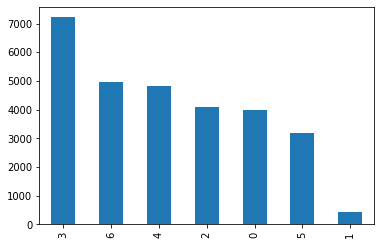

In [60]:
# distribution of emotions data
pd.Series(Y_train).value_counts().plot.bar()

In [10]:
# defining utility function to plot images
# available from: https://github.com/kaushu42 
def plot_grid(images, n_rows=4, n_cols=4, figsize=(5, 5), randomize=True, cmap=None):
    if randomize:
        images = images.copy()
        np.random.shuffle(images)
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
            fig, 111,
            # creates 2x2 grid of axes
            nrows_ncols=(n_rows, n_cols),  
            # pad between axes in inch.
            axes_pad=0.1,  
        )
    for ax, im in zip(grid, iter(images)):
        ax.imshow(im, cmap=cmap)


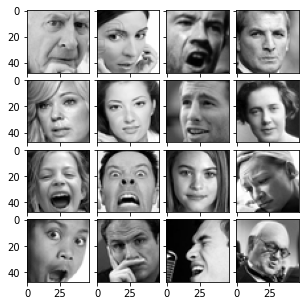

In [11]:
# plotting images using utility function        
plot_grid(X_train, 4, 4, cmap = "gray")

In [63]:
# using categorical function for one hot encoding for trainning and testing
ytrain_cat = to_categorical(Y_train)
ytest_cat = to_categorical(Y_test)

In [64]:
# using agumentation 
generator = ImageDataGenerator(
        rotation_range = 5,  
        zoom_range = 0.0,  
        width_shift_range = 0.1,  
        height_shift_range = 0.1,  
        validation_split = 0.2
)

# generating training and validation for agumentation
train_iterator = generator.flow(X_train, ytrain_cat, batch_size = 128, subset = 'training')
validation_iterator = generator.flow(X_train, ytrain_cat, batch_size = 128, subset = 'validation')                

In [65]:
# flatting the image dataset
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [66]:
x, y = next(train_iterator)

In [67]:
# clearing previous sessions
clear_session()

# defining model layers
input_layers = Input(shape = (48, 48, 1))
layer = Conv2D(256, 3, 1, activation = "relu")(input_layers)
layer = BatchNormalization()(layer)
layer = Conv2D(128, 3, 1, activation = "relu")(layer)
layer = MaxPooling2D()(layer)

layer = Conv2D(64, 3, 1, activation = "relu")(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D()(layer)
layer = Conv2D(32, 3, 1, activation = "relu")(layer)

layer = Conv2D(32, 3, 1, activation = "relu")(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D()(layer)
layer = Conv2D(64, 3, 1, activation = "relu")(layer)
layer = BatchNormalization()(layer)

layer = Flatten()(layer)
layer = Dense(7, activation="softmax")(layer)
# defining input output hidden layer and showing the summary the summary of model
model = Model(inputs=[input_layers], outputs=[layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 256)       1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        256   

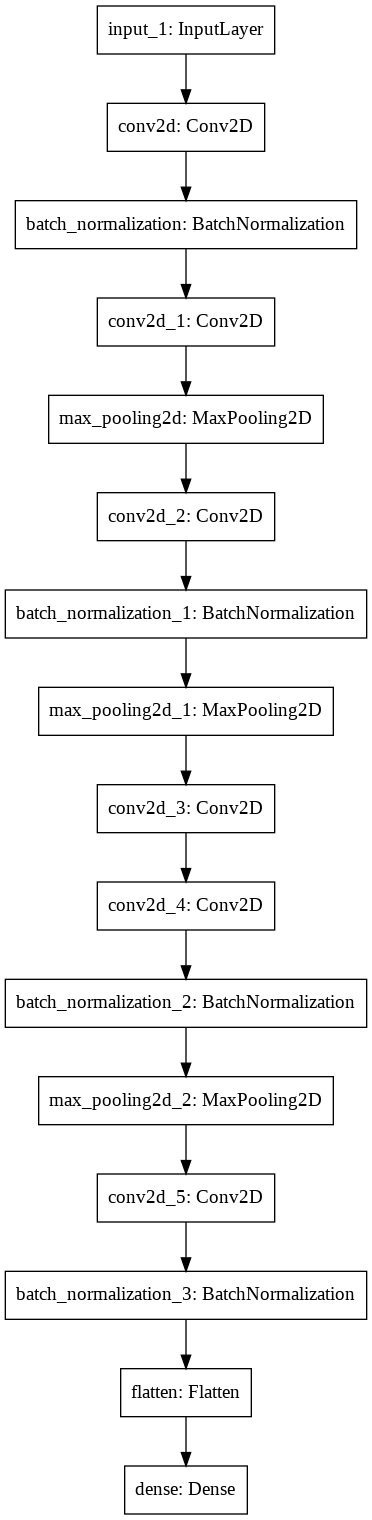

In [68]:
# plotting the model
plot_model(model)

In [69]:
# using earlystopping 
callback = [EarlyStopping(patience = 10, restore_best_weights = True)]

In [70]:
# compiling the created models
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# uniquely distributing class weight of all emotions
weight = compute_class_weight('balanced', np.unique(Y_train),Y_train)
weight = dict(enumerate(weight))

In [71]:
# training model
model_train = model.fit(train_iterator, epochs = 80, batch_size = 64, validation_data =validation_iterator , callbacks = callback, class_weight = weight)


Epoch 1/80
180/180 [==============================] - 19s 100ms/step - loss: 2.1300 - accuracy: 0.1886 - val_loss: 1.9369 - val_accuracy: 0.2007
Epoch 2/80
180/180 [==============================] - 18s 100ms/step - loss: 1.8029 - accuracy: 0.2688 - val_loss: 1.9661 - val_accuracy: 0.1853
Epoch 3/80
180/180 [==============================] - 18s 101ms/step - loss: 1.7555 - accuracy: 0.3121 - val_loss: 1.8860 - val_accuracy: 0.2468
Epoch 4/80
180/180 [==============================] - 18s 101ms/step - loss: 1.6553 - accuracy: 0.3543 - val_loss: 1.8242 - val_accuracy: 0.3238
Epoch 5/80
180/180 [==============================] - 18s 99ms/step - loss: 1.5426 - accuracy: 0.4070 - val_loss: 1.8194 - val_accuracy: 0.3062
Epoch 6/80
180/180 [==============================] - 18s 100ms/step - loss: 1.4671 - accuracy: 0.4279 - val_loss: 1.6922 - val_accuracy: 0.3466
Epoch 7/80
180/180 [==============================] - 18s 100ms/step - loss: 1.4295 - accuracy: 0.4554 - val_loss: 1.6050 - val_acc

In [ ]:
# saving the model
model.save("model.h5")

In [72]:
# evaluating the trained data
model.evaluate(X_test, ytest_cat)

225/225 [==============================] - 2s 9ms/step - loss: 1.1502 - accuracy: 0.5744


[1.1502392292022705, 0.5743939876556396]

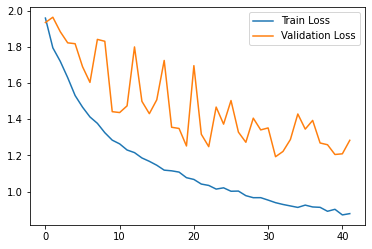

In [73]:
# plotting the graph for train loss and validation data
plt.plot(model_train.history["loss"], label="Train Loss")
plt.plot(model_train.history["val_loss"], label="Validation Loss")
plt.legend()

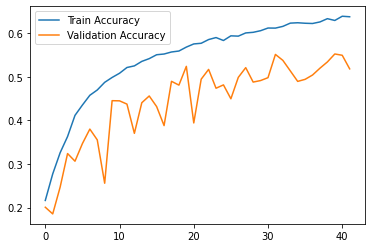

In [74]:
# trainning the data for accuracy and validation accuracy
plt.plot(model_train.history["accuracy"], label="Train Accuracy")
plt.plot(model_train.history["val_accuracy"], label="Validation Accuracy")
plt.legend()

In [75]:
# predicting on trained data
predict_emotion = model.predict(X_train).argmax(axis=1)
print(classification_report(Y_train, predict_emotion))
print(confusion_matrix(Y_train, predict_emotion))

              precision    recall  f1-score   support

           0       0.57      0.54      0.55      3995
           1       0.66      0.81      0.73       436
           2       0.58      0.27      0.37      4097
           3       0.83      0.80      0.82      7215
           4       0.52      0.46      0.49      4830
           5       0.79      0.71      0.75      3171
           6       0.46      0.78      0.58      4965

    accuracy                           0.62     28709
   macro avg       0.63      0.62      0.61     28709
weighted avg       0.64      0.62      0.61     28709

[[2155   83  141  183  426   61  946]
 [  37  355    6    7   16    1   14]
 [ 573   39 1099  243  863  354  926]
 [ 231   17   72 5790  214  113  778]
 [ 429   28  235  228 2203   41 1666]
 [ 116    6  255  221   65 2248  260]
 [ 245    7   88  278  437   32 3878]]


In [76]:
# predicting on test data
predict_emotion = model.predict(X_test).argmax(axis=1)
print(classification_report(Y_test, predict_emotion))
print(confusion_matrix(Y_test, predict_emotion))

              precision    recall  f1-score   support

           0       0.50      0.49      0.49       958
           1       0.56      0.63      0.59       111
           2       0.50      0.21      0.30      1024
           3       0.82      0.78      0.80      1774
           4       0.45      0.39      0.42      1247
           5       0.77      0.69      0.73       831
           6       0.42      0.73      0.53      1233

    accuracy                           0.57      7178
   macro avg       0.57      0.56      0.55      7178
weighted avg       0.59      0.57      0.57      7178

[[ 469   27   45   42  122   21  232]
 [  20   70    4    4    6    1    6]
 [ 155   10  219   73  232   89  246]
 [  62    3   23 1390   53   36  207]
 [ 116    9   63   73  492   11  483]
 [  40    4   62   48   24  577   76]
 [  77    3   23   60  153   11  906]]


Actual Emotion:  Fear
Predicted Emotion:  Neutral


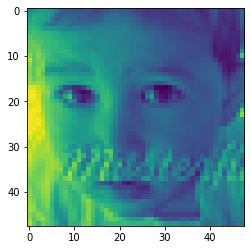

In [84]:
# testing
emotions_tags = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
from random import randint
# generating random number
test_index = randint(0, 7177)
test_image = X_test[test_index].reshape(48, 48)

# plotting the images
plt.imshow(test_image)
y_test = np.stack(Y_test)

# predicting images
print("Actual Emotion: ",emotions_tags[y_test[test_index]])
print("Predicted Emotion: ",emotions_tags[predict_emotion[test_index]])

In [16]:
# loading the trained saved model
model = load_model("model.h5")

# loding harrcascade file
# available from: https://github.com/opencv/opencv/tree/master/data/haarcascades 
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [17]:
# defining 7 emotions
emotions = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Suprise",
    6: "Neutral"
}

In [18]:
# defining function to detect images
def detect_image(face):
#     converting images into grayscale images
    gray_scale = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
#     scaling different images into different sizes from haarcascade file
    faces = classifier.detectMultiScale(gray_scale, 1.1, 5)
    images = []
    for (x, y, width, height) in faces:
#         creating rectangle around the faces and giving color to rectangle in bgr format
        cv2.rectangle(face, (x, y), (x + width, y + height), (0, 255, 0), 2)
#     creating rectangle for multiple face detected
        roi = face[y: y + height, x: x +  width]
#     appending images
        images.append({"image": roi, "x": x, "y": y, "w": width, "h": height})
    return images

In [19]:
# accessing default camera
cam = cv2.VideoCapture(0) 

# loop to display images continously
while True:
#     reading frames and displaying frame
    _, window = cam.read()
    
#     calling the function to detect the images in displayed frame
    images = detect_image(window)
    
#     displyaing the number of faces detected in frame
    cv2.putText(window, f'{len(images)} Face Found', (10, 35), cv2.FONT_HERSHEY_SIMPLEX,  1, (128, 0, 255), 1, cv2.LINE_AA) 
    
#     displaying information to exit the frame
#      cv2.putText(window, "To Exit Press E", (10, 50), cv2.FONT_HERSHEY_SIMPLEX,  1, (128, 0, 255), 1, cv2.LINE_AA) 
    
#     loop to enumerate the images
    for index, img in enumerate(images):
        image = img["image"]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         resizing the images
        image = cv2.resize(image, (48, 48)).reshape(1, 48, 48, 1)
#     predicting the images through trained model
        pred = model.predict(image)[0].argmax()
        emotion = emotions.get(pred, "")
#         displaying the predicted emotion
        cv2.putText(window, f'Emotion: {emotion}', (img["y"], img["x"]), cv2.FONT_HERSHEY_SIMPLEX,  0.5, (0, 0, 255), 1, cv2.LINE_AA) 
    
#     displaying images on window
    cv2.imshow('Emotion Detection', window)
#     setting e key to exit and window and checking pressed key in every 10 millisecond
    if cv2.waitKey(10) & 0xFF == ord('e'):
        break
        
# releasing the used camera and window       
cam.release()
cv2.destroyAllWindows()